Model: Keras EfficientNetB0 model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

Load image folders (not processed, just cropped).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
labels = ['notumor', 'glioma', 'meningioma', 'pituitary']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150

# Load Training Data
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Cropped', 'Training', label)
    for file_name in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, file_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

# Load Testing Data
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Cropped', 'Testing', label)
    for file_name in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, file_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train, y_train = shuffle(X_train, y_train, random_state=101)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)

y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])

Mounted at /content/drive


100%|██████████| 300/300 [00:08<00:00, 36.01it/s] 


In [ ]:
effnet2 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model = effnet2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet2.input, outputs = model)
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet2.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8313 - loss: 0.4372
Epoch 1: val_accuracy improved from -inf to 0.91259, saving model to effnet2.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8317 - loss: 0.4362 - val_accuracy: 0.9126 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 2/12
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 0.1154
Epoch 2: val_accuracy did not improve from 0.91259
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9617 - loss: 0.1154 - val_accuracy: 0.8094 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 3/12
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9749 - loss: 0.0717
Epoch 3: val_accuracy did not improve from 0.91259

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
161/161 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9749 - loss: 0.0718 - val_accuracy: 0.9021 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 4/12
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accu

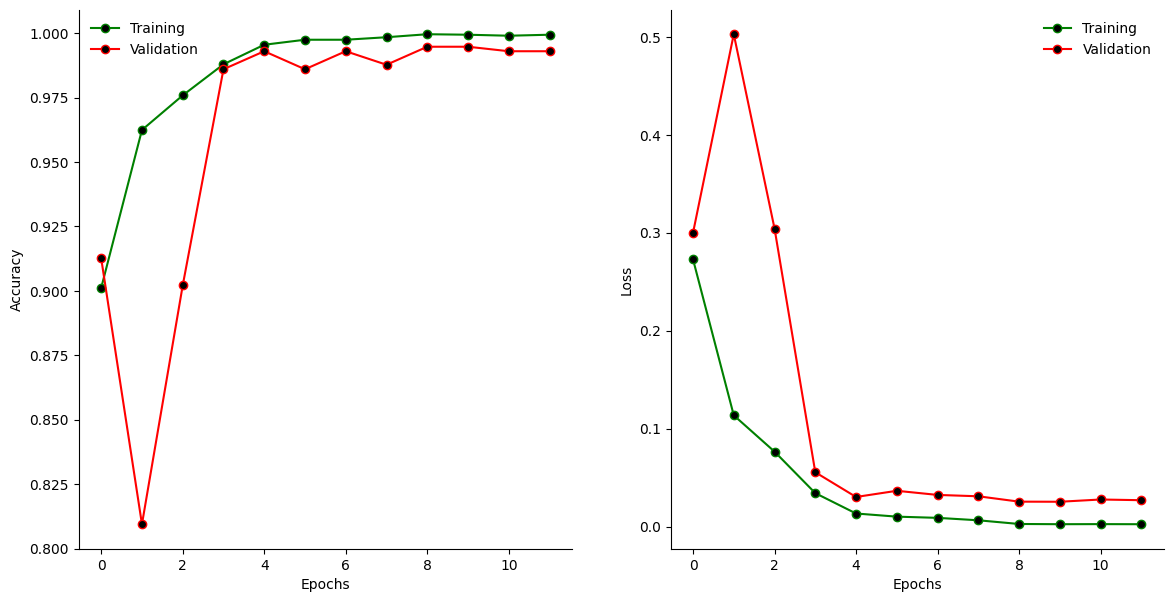

In [ ]:
filterwarnings('ignore')
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='black',color='green',label = 'Training')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='black',color='red',label = 'Validation')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='black',color='green',label ='Training')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='black',color='red',label = 'Validation')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
fig.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step


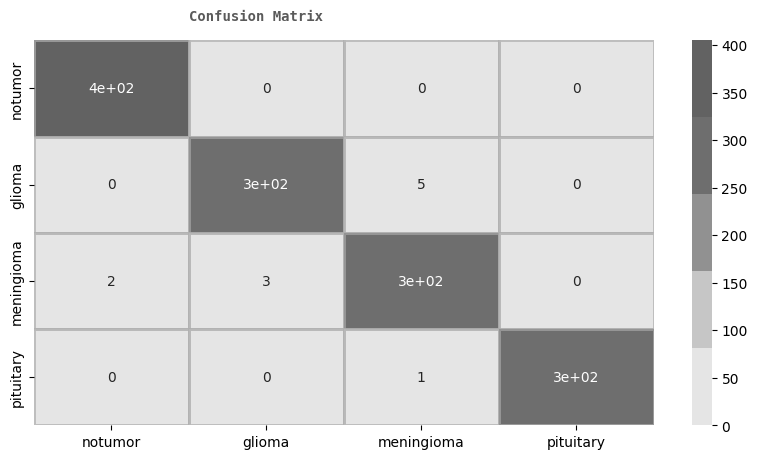

[[405   0   0   0]
 [  0 295   5   0]
 [  2   3 301   0]
 [  0   0   1 299]]


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_dark[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Confusion Matrix',size=10,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()
print(confusion_matrix(y_test_new,pred))

In [ ]:
cm = tf.math.confusion_matrix(y_test_new, pred).numpy()

accuracies = {}
total_correct_predictions = 0
total_predictions = 0

for i, label in enumerate(labels):
    correct_predictions = cm[i, i]
    total_class_predictions = np.sum(cm[i, :])
    accuracy = correct_predictions / total_class_predictions
    accuracies[label] = accuracy
    total_correct_predictions += correct_predictions
    total_predictions += total_class_predictions

print("Accuracy for each category:")
for category, acc in accuracies.items():
    print(f"{category}: {acc:.2f}")

overall_accuracy = total_correct_predictions / total_predictions
print(f"Overall Average Accuracy: {overall_accuracy:.2f}")

Accuracy for each category:
notumor: 1.00
glioma: 0.98
meningioma: 0.98
pituitary: 1.00
Overall Average Accuracy: 0.99


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/trained_model/brain_tumor_detection_cnnmodel2.h5')